Avec les mêmes données des post Python et R nous allons entrainer deux modèles des réseau de neurones
avec Keras et TensorFlow

# importation du dataset et conversion

In [130]:
import numpy as np
import pandas as pd

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str',
                    'Tags': 'str'}

nrows = 20000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )


text_train, tag_train = df_questions.Text, df_questions.Tags

In [131]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=33)
# This builds the word index
tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_matrix(text_train, mode='binary')
Y_train = tokenizer_Y.texts_to_matrix(tag_train, mode='binary')

X_train_padded = pad_sequences(X_train, padding="post")
Y_train_padded = pad_sequences(Y_train, padding="post")

label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

word_index_X = tokenizer_X.word_index
word_index_Y = tokenizer_Y.word_index

reverse_word_index_Y = dict (
    [(value,key) for (key,value) in word_index_Y.items()]
)
print('Found %s unique tokens in the posts.' % len(word_index_X))
print('Found %s unique tokens in the tags.' % len(word_index_Y))

Found 67021 unique tokens in the posts.
Found 2966 unique tokens in the tags.


In [132]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

In [133]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [134]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

In [135]:
history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, Y_val))

Epoch 1/20
24/24 [==============================] - 2s 73ms/step - loss: 0.5400 - acc: 0.0829 - f1_m: 0.0737 - precision_m: 0.0848 - recall_m: 0.2075 - val_loss: 0.1621 - val_acc: 0.7320 - val_f1_m: 0.5134 - val_precision_m: 0.7849 - val_recall_m: 0.3815

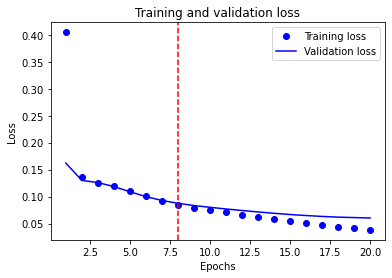

In [136]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=8,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

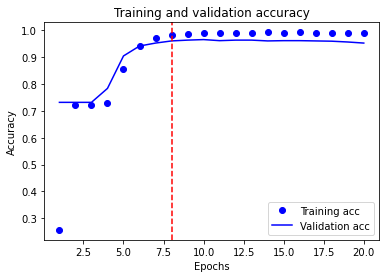

In [137]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x=8,color='red',linestyle='--')

plt.show()

In [138]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)


Loss :  0.05593534931540489
Accuracy :  0.9649999737739563
f1 Score :  0.8169825077056885
precision :  0.9539190530776978
recall :  0.7158581018447876


In [139]:
# On re entraine le modèle du début pour 8 epoch
model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

Epoch 1/8
24/24 [==============================] - 2s 49ms/step - loss: 0.5249 - acc: 0.4294 - f1_m: 0.3478 - precision_m: 0.3784 - recall_m: 0.4424 - val_loss: 0.1542 - val_acc: 0.7320 - val_f1_m: 0.5496 - val_precision_m: 0.7327 - val_recall_m: 0.4398

In [140]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.08603330701589584
Accuracy :  0.9679999947547913
f1 Score :  0.74190354347229
precision :  0.9622141718864441
recall :  0.6050494313240051


In [141]:
Y_predict = model.predict(X_train_padded)

In [142]:
def vector_to_list_of_tags(vect_tag,reverse_word_ind):
    tag_list=[]
    for i in range(len(vect_tag)):
        if vect_tag[i]>0 :
            tag_list.append(reverse_word_ind.get(i,'?'))
    return tag_list

In [143]:
id_sample = 6

print('reverse word index Y : ',reverse_word_index_Y)
print('Tags before vectoring : ',tag_train[id_sample])
print('Tags vectorize matrix : ',Y_train_padded[id_sample])

sample_tag = vector_to_list_of_tags(Y_train_padded[id_sample],reverse_word_index_Y)
print('Tags vectorized : ',sample_tag)

Y_predict_ones = (Y_predict>0.5).astype(int)
sample_tag_pred = vector_to_list_of_tags(Y_predict_ones[id_sample],reverse_word_index_Y)
print('Tags predicted matrix: ',np.around(Y_predict[id_sample], decimals=1))
print('Tags predicted : ',sample_tag_pred)

reverse word index Y :  {1: 'python', 2: 'r', 3: 'django', 4: 'ggplot2', 5: 'list', 6: 'numpy', 7: 'string', 8: 'dataframe', 9: 'x', 10: 'matplotlib', 11: '3', 12: '2', 13: 'data', 14: 'dictionary', 15: 'regex', 16: 'file', 17: 'pandas', 18: 'plot', 19: '7', 20: 'table', 21: 'dplyr', 22: 'datetime', 23: 'testing', 24: 'faq', 25: 'flask', 26: 'class', 27: 'sqlalchemy', 28: 'c', 29: 'function', 30: 'import', 31: 'performance', 32: 'windows', 33: 'models', 34: 'scipy', 35: 'exception', 36: 'arrays', 37: 'unicode', 38: 'unit', 39: 'csv', 40: 'markdown', 41: 'date', 42: 'sorting', 43: 'matrix', 44: 'variables', 45: 'shiny', 46: 'json', 47: 'io', 48: 'linux', 49: 'time', 50: 'module', 51: 'multithreading', 52: 'knitr', 53: 'image', 54: 'tkinter', 55: 'mysql', 56: 'memory', 57: 'formatting', 58: 'pip', 59: 'oop', 60: 'statistics', 61: 'rstudio', 62: 'package', 63: 'processing', 64: 'syntax', 65: 'algorithm', 66: 'virtualenv', 67: 'google', 68: 'logging', 69: 'line', 70: 'random', 71: 'parsing

In [144]:
np.sum(Y_predict_ones,axis=0)

array([    0, 10054,  3899,     0,   200,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [145]:
id_sample = 100
new_post = text_train[id_sample]
new_post_vect = vect_X.transform([new_post])
y_predict = clf.predict(new_post_vect)

tags = np.argsort(y_predict[0,:])[::-1][:10].tolist()
scores = np.sort(y_predict[0,:])[::-1][:10]
print(df_questions.Title_raw[id_sample],'\n')
print(df_questions.Body[id_sample],'\n')
print(text_train[id_sample])
for tag,score in zip(tags,scores) :
    if score > 0  :
        print(feature_names_Y[tag],score)

NameError: name 'vect_X' is not defined

In [ ]:
np.argmax((Y_predict[0:3]>0.55).astype(int))

In [ ]:
tag_train[0:3]

In [ ]:
tokenizer_X.matrix_to_text((Y_predict[0:3]>0.55).astype(int))